## Imports & Consts

In [1]:
import pickle
import pandas as pd

import src.utils.funcs as funcs

In [2]:
TRAIN_MODEL = True
TEST_TOP_FEATURES = True
OPTIMIZE = False

In [3]:
save_model_file = 'src/models/rf_model_top.pickle' if TEST_TOP_FEATURES else 'src/models/rf_model.pickle'
save_scores_file = 'src/artifacts/scores_top.pickle' if TEST_TOP_FEATURES else 'src/artifacts/scores.pickle'
save_outputs_file = 'src/artifacts/output_top.pickle' if TEST_TOP_FEATURES else 'src/artifacts/output.pickle'

In [4]:
# save_model_file = 'src/models/lgbm_model_top.pickle' if TEST_TOP_FEATURES else 'src/models/lgbm_model.pickle'
# save_scores_file = 'src/artifacts/lgbm_scores_top.pickle' if TEST_TOP_FEATURES else 'src/artifacts/lgbm_scores.pickle'
# save_outputs_file = 'src/artifacts/lgbm_output_top.pickle' if TEST_TOP_FEATURES else 'src/artifacts/lgbm_output.pickle'

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = funcs.prepare_X_y(*funcs.prepare_data(*funcs.get_data_from_files()), reduced=True)
preproc = funcs.make_preprocess_pipeline(X_train)

preproc_smote = ImbPipeline(steps=[
    ("preprocess", preproc),
    ("smote", SMOTE())
])

preproc_smote

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'EXT_SOURCE_2', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN',
       'CNT_FAM_MEMBERS', 'CREDIT_TERM', 'NONLIVINGAREA_MEDI', 'EXT_SOURCE_1',
       'DAYS_LAST_PHONE_CHANGE', 'NONLIVINGAREA_MODE', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'NONLIVINGAREA_AVG'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  Index([], dtype='object'))])),
                ('smote', SMOTE())])

## Training / Loading

In [6]:
if TRAIN_MODEL:
    # model_pipeline, scores, output = funcs.test_run_with_lgbm(test_top_features=TEST_TOP_FEATURES, optimize=OPTIMIZE)
    model_pipeline, scores, output = funcs.test_run_with_randomforest(test_top_features=TEST_TOP_FEATURES, tracking=False, optimize=OPTIMIZE)
else:
    with open(save_model_file, 'rb') as file:
        model_pipeline = pickle.load(file)
    with open(save_scores_file, 'rb') as file:
        scores = pickle.load(file)
    with open(save_outputs_file, 'rb') as file:
        output = pickle.load(file)


Data Ready
Model setup !
Training...
X_train.shape=(246005, 15)
Training DONE!
Predicting...
          count  proportion
DECISION                   
OK        39372     0.80773
NOT OK     9372     0.19227


In [7]:
if TRAIN_MODEL:
    with open(save_model_file, 'wb') as file:
        pickle.dump(model_pipeline, file)
    with open(save_scores_file, 'wb') as file:
        pickle.dump(scores, file)
    with open(save_outputs_file, 'wb') as file:
        pickle.dump(output, file)

In [8]:
s_train, s_test = scores.values()

In [9]:
s_train, s_test

({'acuracy': 0.9900245929960774,
  'precision': 0.9935352160598843,
  'recall': 0.8821752265861027,
  'f1': 0.9345495279244679,
  'f5': 0.8859947017703556,
  'ROC_AUC': np.float64(0.9993888741899037)},
 {'acuracy': 0.9081818477447888,
  'precision': 0.22763578274760382,
  'recall': 0.05740181268882175,
  'f1': 0.09168409200579057,
  'f5': 0.059101749124640085,
  'ROC_AUC': np.float64(0.6356158924238957)})

## Features Importance

### Global

In [10]:
feature_importances = model_pipeline['clf'].feature_importances_
feature_names = model_pipeline.named_steps['preprocess'].get_feature_names_out()

df = pd.DataFrame(feature_importances, index=feature_names, columns=["importance"])
top_features = df["importance"].sort_values(ascending=False).head(15)

[x.split("__")[1] for x in top_features.index]

['OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'CNT_FAM_MEMBERS',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_MEDI',
 'CREDIT_TERM',
 'NONLIVINGAREA_AVG',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_1',
 'CNT_CHILDREN']

<Axes: >

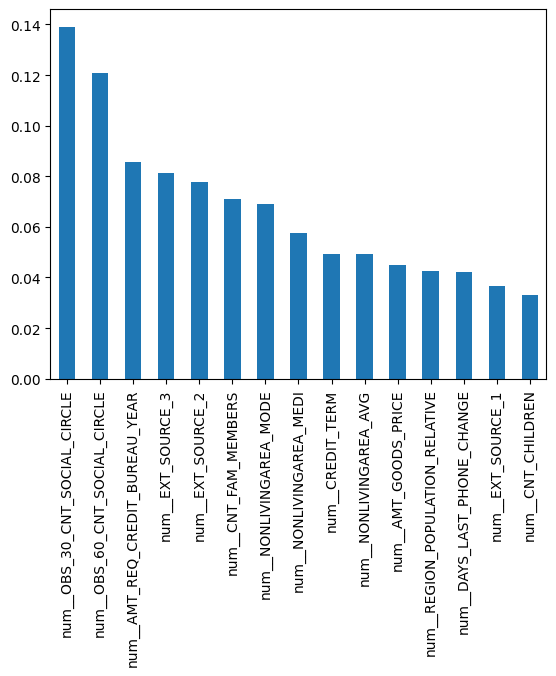

In [11]:
import matplotlib.pyplot as plt

top_features.plot(kind='bar')

### Local

Index([73732], dtype='int64')


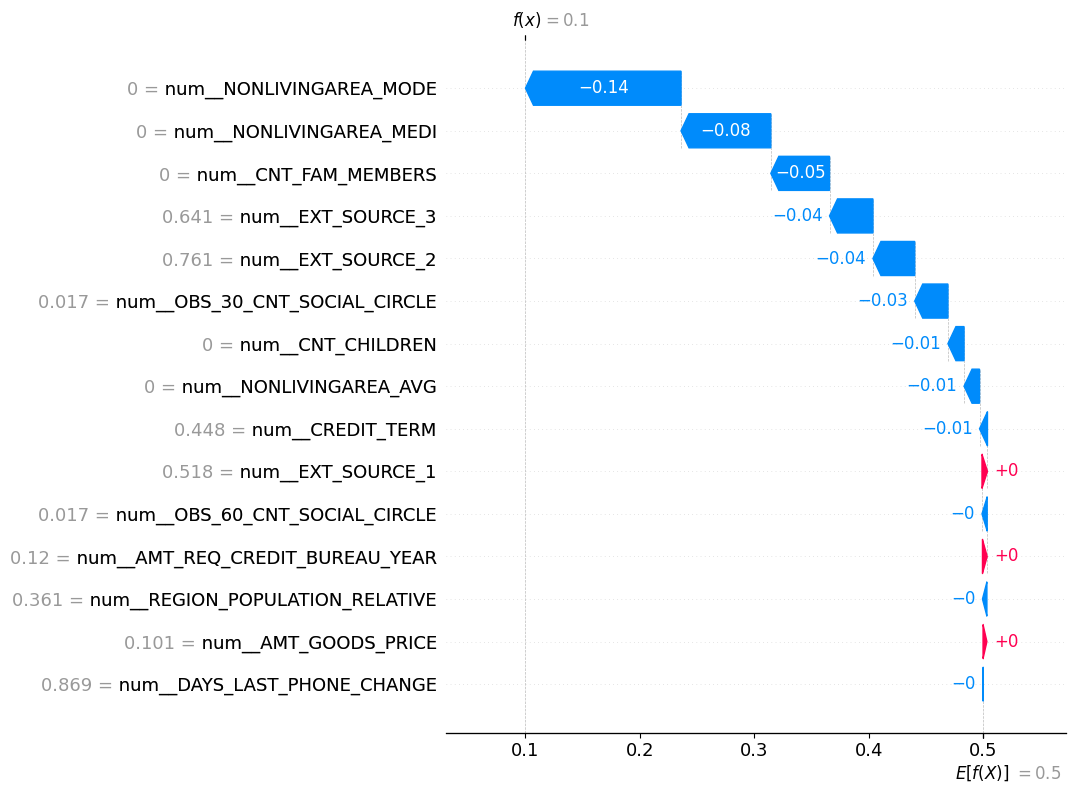

In [12]:
import shap

explainer = shap.TreeExplainer(model_pipeline['clf'])

X_test_example = X_test.sample(
    1,
    # random_state=42
)

print(f"{X_test_example.index}")

X_test_transformed = model_pipeline[:-2].transform(X_test_example)
shap_values = explainer(X_test_transformed)
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0,:,1],
        feature_names=feature_names
    ),
    max_display=21,
)

## Confusion Matrix & Report

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import src.utils.funcs as funcs

In [15]:
train, test = funcs.prepare_data(*funcs.get_data_from_files())
X_train, X_test, y_train, y_test = funcs.prepare_X_y(train, test)

y_pred = model_pipeline.predict(X_test)

In [16]:
print(f"{y_test.shape=}")

y_test.shape=(61502,)


[[0.90354785 0.01572307]
 [0.07609509 0.004634  ]]


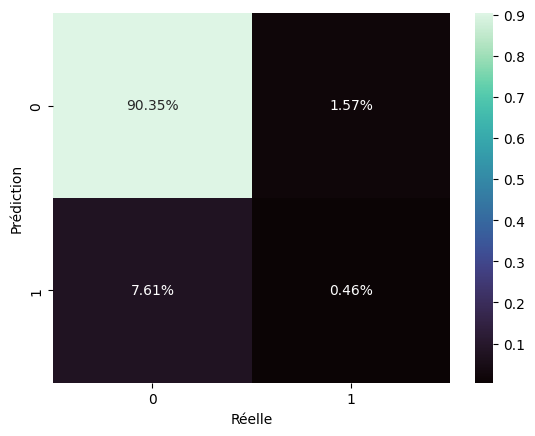

In [17]:
cm = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    normalize='all'
)
print(cm)

sns.heatmap(cm, cmap="mako", annot=True, fmt='.2%')

plt.xlabel('Réelle')
plt.ylabel('Prédiction');

In [18]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56537
           1       0.23      0.06      0.09      4965

    accuracy                           0.91     61502
   macro avg       0.57      0.52      0.52     61502
weighted avg       0.87      0.91      0.88     61502



## Final

In [19]:
output

,SK_ID_CURR,TARGET,DECISION
0,100001,0.000000,OK
1,100005,0.000000,OK
2,100013,0.100000,OK
3,100028,0.000000,OK
4,100038,0.300000,NOT OK
...,...,...,...
48739,456221,0.000000,OK
48740,456222,0.000000,OK
48741,456223,0.000000,OK
48742,456224,0.200000,OK


In [20]:
pd.concat([
    output["DECISION"].value_counts(),
    output["DECISION"].value_counts(normalize=True),
], axis=1)

,count,proportion
DECISION,,
OK,39372,0.80773
NOT OK,9372,0.19227
